# Deep Learning - Project 2 - Convolutional Neural Networks


## Part 1 - Implementation of an image classifier

### 0) Imports

In [ ]:
import os
import math
import numpy as np 
import time
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()
from PIL import Image
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [ ]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

print("Using torch", torch.__version__)

Using torch 1.13.0+cu116


In [ ]:
# set seeds for reproducibility
torch.manual_seed(8)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### 1) Download the data and load it in the Notebook

In [ ]:
caltech_data = dset.Caltech101("data", target_type="category", download=True)
categories = caltech_data.categories

Files already downloaded and verified


Number of samples:  8677


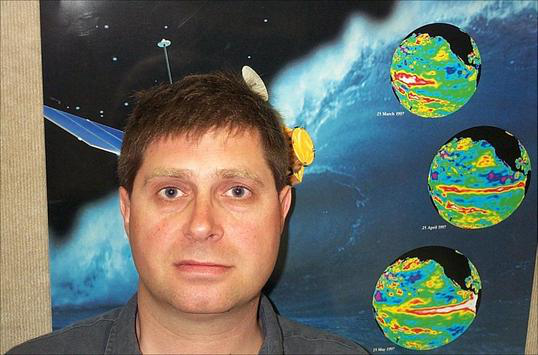

target: Faces, shape: (355, 538, 3)


In [ ]:
N = 3 # load 4th sample
print('Number of samples: ', len(caltech_data))
img, target = caltech_data[N]
display(img)
print(f"target: {categories[target]}, shape: {np.array(img).shape}")

### 2) Standardize the images

In [ ]:
transform_img = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x) # unify number of channels
])

caltech_data = dset.Caltech101("data", transform=transform_img, target_type="category", download=True)

Files already downloaded and verified


In [ ]:
def mean_and_std(loader):
    counter = 0
    ev = torch.empty(3)
    var = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        number_of_pixels = b * h * w
        # sums over each channel
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        # expected value
        ev = (counter * ev + sum_) / (counter + number_of_pixels)
        # variance
        var = (counter * var + sum_of_square) / (counter + number_of_pixels)
        counter += number_of_pixels

    mean, std = ev, torch.sqrt(var - ev ** 2)        
    return mean,std

In [ ]:
BATCH_SIZE = 4
image_data_loader = torch.utils.data.DataLoader(
  caltech_data, 
  batch_size = BATCH_SIZE, 
  shuffle=False,
  num_workers=0)

mean, std = mean_and_std(image_data_loader)
print(f"Statistics of the whole dataset:\nmean = {mean}\nstd = {std}")

Statistics of the whole dataset:
mean = tensor([0.5390, 0.5173, 0.4887])
std = tensor([0.3056, 0.2996, 0.3121])


In [ ]:
# https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html 
transform_standardization = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x), # unify number of channels
    transforms.Normalize(mean, std)
])

caltech_data = dset.Caltech101("data", transform=transform_standardization, target_type="category", download=True)

Files already downloaded and verified


In [ ]:
# CHECK WHETHER mean == 0 and std == 1
image_data_loader_stand = torch.utils.data.DataLoader(
  caltech_data, 
  batch_size = BATCH_SIZE, 
  shuffle=False,
  num_workers=0)

mean, std = mean_and_std(image_data_loader_stand)
print(f"Statistics of the whole dataset:\nmean = {mean}\nstd = {std}")
assert torch.le(mean.abs(), 0.001).all(), "Not all of the channels have mean equal to 0"
assert torch.isclose(std, torch.ones_like(std), atol=0.001).all(), "Not all of the channels have standard deviation equal to 1"

Statistics of the whole dataset:
mean = tensor([-4.4689e-07, -1.2186e-08,  8.0951e-07])
std = tensor([1.0000, 1.0000, 1.0000])


In [ ]:
def display_img_tensor(img):
    images_np = img.numpy()
    img_plt = images_np.transpose(1,2,0)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(np.clip(img_plt, 0, 1))

target: Faces, shape: (3, 256, 256)


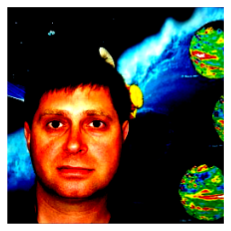

In [ ]:
N = 3 # load 4th sample
img, target = caltech_data[N]
display_img_tensor(img)
print(f"target: {categories[target]}, shape: {np.array(img).shape}")

### 3) Divide the collection into Train and Test set

In [ ]:
# check the number of samples in each class
classes_count = dict(Counter(caltech_data.y))
classes_count = sorted(classes_count.items(), key=lambda item: item[1], reverse=True)
print("(id, number of samples)")
print(*classes_count[:35])

(id, number of samples)
(5, 800) (3, 798) (0, 435) (1, 435) (94, 239) (2, 200) (12, 128) (19, 123) (55, 114) (23, 107) (47, 100) (46, 99) (13, 98) (16, 91) (50, 88) (63, 87) (54, 86) (86, 86) (92, 86) (15, 85) (39, 85) (90, 85) (81, 84) (75, 82) (57, 81) (51, 80) (58, 78) (65, 76) (35, 75) (93, 75) (26, 73) (27, 70) (25, 69) (34, 68) (31, 67)


In [ ]:
# take 20 classes with about 80 examples each
chosen_classes = [item[0] for item in classes_count[12:32]]
res_list = map(categories.__getitem__, chosen_classes)
print("Selected classes:")
print(*res_list)

Selected classes:
brain butterfly helicopter menorah kangaroo starfish trilobite buddha ewer sunflower scorpion revolver laptop ibis llama minaret electric_guitar umbrella crab crayfish


In [ ]:
idx, classes = [], []

for i, cl in enumerate(caltech_data.y):
    if cl in chosen_classes:
        idx.append(i)
        classes.append(cl)

In [ ]:
# split
train_indices, test_indices = train_test_split(idx, test_size=0.3, stratify=classes)
len(train_indices), len(test_indices)

(1155, 496)

In [ ]:
BATCH_SIZE = 4

train_set = torch.utils.data.Subset(caltech_data, train_indices)
test_set = torch.utils.data.Subset(caltech_data, test_indices)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [ ]:
def check_sets(loader, show_idx=-1):
    stats_dict = dict()
    i = 0
    for images, labels in loader:
        for  img, lab in zip(images, labels):
          if i == show_idx:
              print('EXEMPLARY IMAGE')
              print(f'Label: {categories[lab]}')
              print(f'Shape: {img.shape}')
              display_img_tensor(img)
          i+=1
          if categories[lab] in stats_dict.keys():
            stats_dict[categories[lab]] += 1
          else:
            stats_dict[categories[lab]] = 1
    return stats_dict

EXEMPLARY IMAGE
Label: laptop
Shape: torch.Size([3, 256, 256])


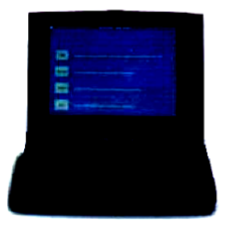

In [ ]:
train_stats = check_sets(train_loader, show_idx=10)

EXEMPLARY IMAGE
Label: menorah
Shape: torch.Size([3, 256, 256])


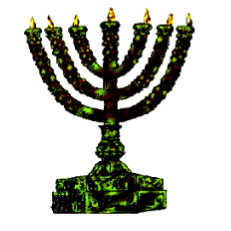

In [ ]:
test_stats = check_sets(test_loader, show_idx=10)

In [ ]:
assert train_stats.keys() == test_stats.keys()
denom_train = sum(train_stats.values()) # or alternatively len(train_indices)
denom_test = sum(test_stats.values())
print("CHECK CLASS PROPORTIONS IN BOTH SETS:")
for key in train_stats.keys():
    print(f'key: {str.upper(key)}\t\ttrain: {round(train_stats[key]/denom_train*100, 2)}%,\t\ttest: {round(test_stats[key]/denom_test*100,2)}%')

CHECK CLASS PROPORTIONS IN BOTH SETS:
key: ELECTRIC_GUITAR		train: 4.5%,		test: 4.64%
key: BUTTERFLY		train: 5.54%,		test: 5.44%
key: BUDDHA		train: 5.11%,		test: 5.24%
key: KANGAROO		train: 5.19%,		test: 5.24%
key: STARFISH		train: 5.19%,		test: 5.24%
key: REVOLVER		train: 4.94%,		test: 5.04%
key: EWER		train: 5.11%,		test: 5.24%
key: LAPTOP		train: 4.94%,		test: 4.84%
key: LLAMA		train: 4.76%,		test: 4.64%
key: MINARET		train: 4.59%,		test: 4.64%
key: TRILOBITE		train: 5.19%,		test: 5.24%
key: SUNFLOWER		train: 5.11%,		test: 5.24%
key: BRAIN		train: 5.97%,		test: 5.85%
key: HELICOPTER		train: 5.37%,		test: 5.24%
key: CRAYFISH		train: 4.24%,		test: 4.23%
key: CRAB		train: 4.42%,		test: 4.44%
key: UMBRELLA		train: 4.59%,		test: 4.44%
key: SCORPION		train: 5.11%,		test: 5.04%
key: IBIS		train: 4.85%,		test: 4.84%
key: MENORAH		train: 5.28%,		test: 5.24%


### 4) Define the model 

### 5) Train the model

### 6) Save the model to disk

### 7) Summary of the Part 1 - describe your observations

## Part 2 - Experimental comparative analysis

In [ ]:
# choose >= 3 tasks